<a href="https://colab.research.google.com/github/wonderalexandre/MorphoTreeAdjust/blob/main/notebooks/morphoTreeAdjust_example_leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Library

In [1]:
!pip install morphoTreeAdjust
!pip install PrettyPrintTree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for morphoTreeAdjust: filename=morphoTreeAdjust-0.1.8-cp311-cp311-linux_x86_64.whl size=202214 sha256=cea9e6a0ba8340fd1f6101669aa3a918400243fd15cef13f935673e42f949c6b
  Stored in directory: /root/.cache/pip/wheels/9b/8e/68/5849f077549d26da05e983cbc89824b1098300044fe5dcc600
Successfully built morphoTreeAdjust
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 7.8 MB/s eta 0:00:00


In [3]:
import sys
sys.path.append("/opt/anaconda3/lib")

# 2. Importing library and defining plotting functions

In [6]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import morphoTreeAdjust as mta

from PrettyPrint import PrettyPrintTree
from colorama import Fore, Back

printTree = PrettyPrintTree(
    lambda node: node.children,
    lambda node: (str(node.id) + ": " +str(node.level) +": " +str(node.area)), color=Back.BLACK + Fore.WHITE,
    start_message=lambda node: f'Each node is represented by <index>: <gray level>: <area>\n'
)

def showLevelSets(img_f):
    print("Upper and lower level sets where in black are foreground pixels and white are background pixels")
    t_values = np.unique(img_f)
    len = np.size(t_values)
    max_value = np.max(img_f)
    fig, axes = plt.subplots(len, 2, figsize=(5, 15))

    # Preenchendo os subplots com imagens limiares
    for i, t in enumerate(t_values):
        # Primeira coluna: img_f >= t
        thr = t_values[i]
        img_threshold_ge = np.where(img_f >= thr, 1, 0)
        axes[i, 0].imshow(img_threshold_ge, cmap='gray_r', vmax=1, vmin=0, interpolation='nearest')
        axes[i, 0].set_title(f'image ≥ {t}')
        axes[i, 0].axis('off')
        axes[i, 0].add_patch(plt.Rectangle((0, 0), img_threshold_ge.shape[1] - 1, img_threshold_ge.shape[0] - 1,
                                   edgecolor='red', linewidth=0.5, fill=False))
        # Segunda coluna: img_f <= t
        thr = t_values[len - i -1]
        img_threshold_le = np.where(img_f <= thr, 1, 0)
        axes[i, 1].imshow(img_threshold_le, cmap='gray_r',vmax=1, vmin=0, interpolation='nearest')
        axes[i, 1].set_title(f'image ≤ {thr}')
        axes[i, 1].axis('off')
        axes[i, 1].add_patch(plt.Rectangle((0, 0), img_threshold_le.shape[1] - 1, img_threshold_le.shape[0] - 1,
                                   edgecolor='blue', linewidth=0.5, fill=False))

    # Ajuste de layout para evitar sobreposição
    plt.tight_layout()
    plt.show()


def computeCentroid(cnps):
    closest_pixel = cnps[len(cnps)//2]
    px, py = closest_pixel // num_cols, closest_pixel % num_cols
    return px, py

def showTree(tree):
    if(tree.isMaxtree):
        print("Imagem and its max-tree representation. The indexes of max-tree nodes are shown as label in the imagem.")
    else:
        print("Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.")
    img_vector = tree.reconstructionImage()
    ids_position = []

    for node in tree.root.postOrderTraversal():
      px, py = computeCentroid(node.cnps)
      ids_position.append( (node.id, px, py) )

    # Plota a imagem
    plt.figure(figsize=(8, 6))
    image = img_vector.reshape(tree.numRows, tree.numCols)
    # Adicionando uma borda ao redor da imagem
    ax = plt.gca()  # Obtém o eixo atual
    ax.add_patch(plt.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1,
                               edgecolor='red', linewidth=0.5, fill=False))

    plt.imshow(image, cmap='gray')

    # Adiciona rótulos nos centróides fictícios
    for i, (id, x, y) in enumerate(ids_position):
        plt.text(y, x, f'•{id}', color='red', fontsize=9)


    plt.axis('off')
    plt.show()
    printTree(tree.root)

def showNode(node):
    image = node.recNode().reshape(num_rows, num_cols)
    ax = plt.gca()  # Obtém o eixo atual
    ax.imshow(image, cmap='gray_r')
    ax.add_patch(plt.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1,
                               edgecolor='red', linewidth=0.5, fill=False))
    ax.set_title(f"{node}")
    ax.axis("off")

def buildMapIds(tree):
    mapIds = np.zeros(num_rows*num_cols)
    for p in range(num_rows*num_cols):
        mapIds[p] = tree.getSC(p).id
    return mapIds


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

def getNodeContour(tree, node):
    adj = mta.AdjacencyRelation(num_rows, num_cols, 1.5)  # Relação de adjacência
    contour = []

    for idP in node.cnps:  # Percorre os pixels do nó
        for idQ in adj.getAdjPixels(idP):  # Verifica seus vizinhos
            sc_p = tree.getSC(idP)
            sc_q = tree.getSC(idQ)

            if sc_p and sc_q and sc_p.id != sc_q.id:  # Verifica se são nós diferentes
                pixel_x = idQ // num_cols
                pixel_y = idQ % num_cols
                contour.append((pixel_y, pixel_x))  # (x=coluna, y=linha)

    return contour



def showNodesOfSubtree(tree, root):
    image = tree.reconstructionImage().reshape(num_rows, num_cols)
    adj = mta.AdjacencyRelation(num_rows, num_cols, 1.5)
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    # Desenha a borda do retângulo em vermelho
    ax.add_patch(patches.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1,
                                   edgecolor='red', linewidth=0.5, fill=False))

    colormap = plt.colormaps['Paired']  # Obtém a paleta de cores (versão compatível)
    ids_position = []
    map_adj = {}

    for node in root.BFSTraversal():
        contours_x = []
        contours_y = []
        color = colormap(node.id % 10)  # Seleciona cor baseada no ID do nó

        # Obtém um ponto de referência do nó para exibir seu ID
        (px, py) = computeCentroid(node.cnps)
        ids_position.append((node.id, px, py, color))

        contour = getNodeContour(tree, node)
        if contour:
            contour_x, contour_y = zip(*contour) if contour else ([], [])
            ax.scatter(contour_x, contour_y, color=color, s=0.5, label=f"Node {node.id}")

        for idP in node.cnps:
            for idQ in adj.getAdjPixels(idP):
                sc_p = tree.getSC(idP)
                sc_q = tree.getSC(idQ)
                if sc_p and sc_q and sc_p.id != sc_q.id:
                    if idQ not in map_adj:
                        nodeQ = sc_q
                        (qx, qy) = computeCentroid(nodeQ.cnps)
                        map_adj[idQ] = (nodeQ.id, qx, qy)




    # Plota os IDs dos nós vizinhos (em vermelho)
    for node_id, x, y in map_adj.values():
        plt.text(y, x, f'{node_id}', color='red', fontsize=9)

    # Plota os IDs dos nós no centro
    for node_id, x, y, color in ids_position:
        plt.text(y, x, f'{node_id}*', color=color, fontsize=9)


    ax.set_title(f"Subárvore com raiz {root}")
    ax.axis("off")  # Remove os eixos
    plt.show()


# 3. Creating the mintree and maxtree of an input image

- Image of the JMIV paper

Upper and lower level sets where in black are foreground pixels and white are background pixels


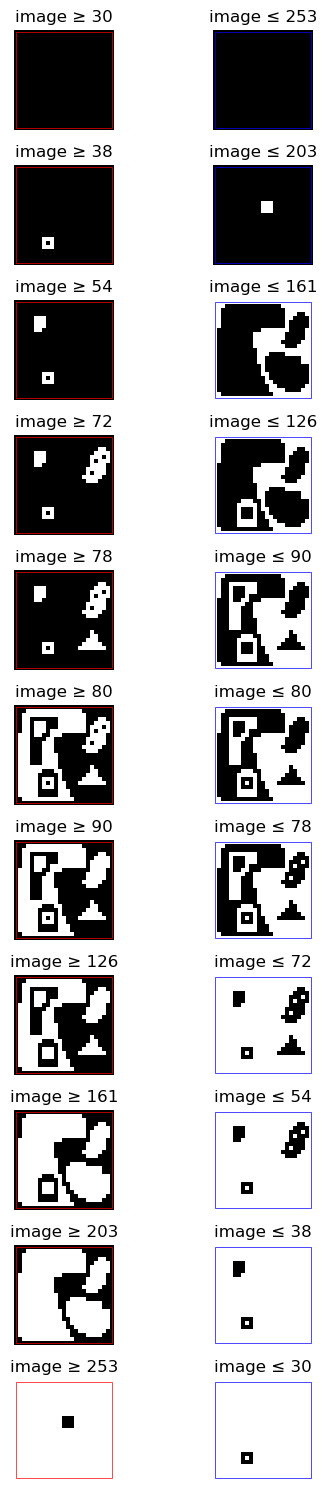




Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


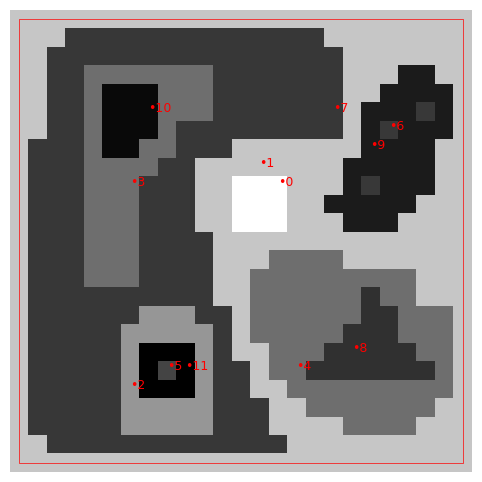

Each node is represented by <index>: <gray level>: <area>

                                 0: 253: 625 
                                      |
                                 1: 203: 616 
                     ┌────────────────┴────┬────────────┐
                2: 161: 277            4: 126: 84   6: 80: 38 
           ┌─────────┴─────────┐           |            |     
      3: 126: 244           5: 90: 9   8: 72: 18    9: 54: 35 
     ┌─────┴──────┐            |                              
 7: 78: 191   10: 38: 11   11: 30: 8 



Imagem and its max-tree representation. The indexes of max-tree nodes are shown as label in the imagem.


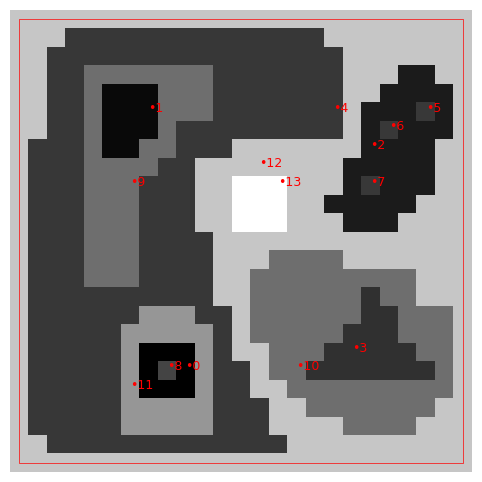

Each node is represented by <index>: <gray level>: <area>

                                                         0: 30: 625 
                                           ┌─────────────────┴─────────────────┐
                                       1: 38: 616                           8: 90: 1 
                                           |                                         
                                       2: 54: 605                                    
                   ┌───────────────────────┴──┬──────────┬──────────┐                
               3: 72: 567                  5: 80: 1   6: 80: 1   7: 80: 1            
                   |                                                                 
               4: 78: 549                                                            
     ┌─────────────┼──────────────┐                                                  
 9: 126: 42   10: 126: 292   11: 161: 24                                             
                 

In [10]:
img_jmiv =  np.array([
[203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203],
[203,203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203,203],
[203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203],
[203,203, 78, 78,126,126,126,126,126,126,126, 78, 78, 78, 78, 78, 78, 78,203,203,203, 54, 54,203,203],
[203,203, 78, 78,126, 38, 38, 38,126,126,126, 78, 78, 78, 78, 78, 78, 78,203,203, 54, 54, 54, 54,203],
[203,203, 78, 78,126, 38, 38, 38,126,126,126, 78, 78, 78, 78, 78, 78, 78,203, 54, 54, 54, 80, 54,203],
[203,203, 78, 78,126, 38, 38, 38,126, 78, 78, 78, 78, 78, 78, 78, 78, 78,203, 54, 80, 54, 54, 54,203],
[203, 78, 78, 78,126, 38, 38,126,126, 78, 78, 78,203,203,203,203,203,203,203, 54, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126,126, 78, 78,203,203,203,203,203,203,203,203, 54, 54, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203,203, 54, 80, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203, 54, 54, 54, 54, 54,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203,203, 54, 54, 54,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,203,203,203,203,203,203,203,203,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,203,126,126,126,126,203,203,203,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,126,126,126,126,126,126,126,126,126,203,203,203],
[203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,126,126,126,126,126,126, 72,126,126,203,203,203],
[203, 78, 78, 78, 78, 78, 78,161,161,161, 78, 78,203,126,126,126,126,126,126, 72, 72,126,126,126,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78,203,126,126,126,126,126, 72, 72, 72,126,126,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 30, 30,161, 78,203,203,126,126,126, 72, 72, 72, 72, 72,126,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 90, 30,161, 78, 78,203,126,126, 72, 72, 72, 72, 72, 72, 72,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 30, 30,161, 78, 78,203,203,126,126,126,126,126,126,126,126,126,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78, 78, 78,203,203,126,126,126,126,126,126,126,203,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78, 78, 78,203,203,203,203,126,126,126,126,203,203,203],
[203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203,203,203,203],
[203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203]
], dtype=np.uint8)



num_rows, num_cols = img_jmiv.shape
img_jmiv_vector = img_jmiv.ravel()

maxtree = mta.ComponentTree(img_jmiv_vector, num_rows, num_cols, True)
mintree = mta.ComponentTree(img_jmiv_vector, num_rows, num_cols, False)

showLevelSets(img_jmiv)
print("\n\n")
showTree(mintree)
print("\n\n")
showTree(maxtree)


# 4. Pruning a leaf of the max-tree and adjusting the min-tree

### 4.1 Selecting the leaf

List of leaves of the min-tree:
	 [NodeCT(id=9, level=54), NodeCT(id=8, level=72), NodeCT(id=11, level=30), NodeCT(id=10, level=38), NodeCT(id=7, level=78)] 



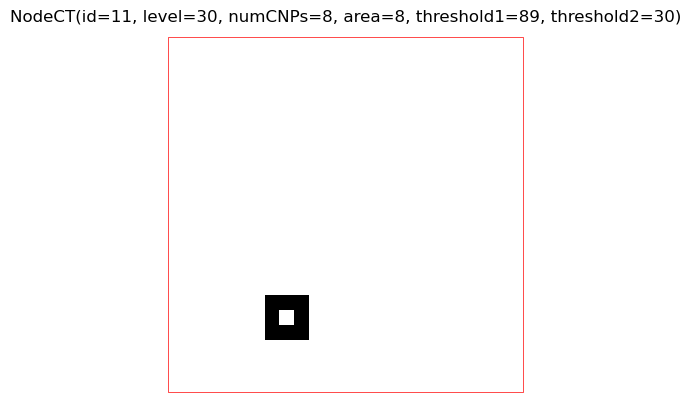

In [14]:
leaves_mintree = mintree.leaves()
print("List of leaves of the min-tree:\n\t", leaves_mintree, "\n")

L = leaves_mintree[2]
showNode(L)

In [16]:
adjust = mta.ComponentTreeAdjustmentByLeaf(mintree, maxtree)

oldGrayLevel = L.level
newGrayLevel = L.parent.level

(F_λ, F_λb) = adjust.buildCollections(maxtree, L, newGrayLevel)

print("f(p) = a = ", oldGrayLevel)
print("g(p) = b = ", newGrayLevel)
print("F_λ:", F_λ)
print("F_λ>b:", F_λb)

f(p) = a =  30
g(p) = b =  90
F_λ: {30: [NodeCT(id=0, level=30)], 38: [NodeCT(id=1, level=38)], 54: [NodeCT(id=2, level=54)], 72: [NodeCT(id=3, level=72)], 78: [NodeCT(id=4, level=78)], 90: [NodeCT(id=8, level=90)]}
F_λ>b: set()


The reconstruction images are equals? True
Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


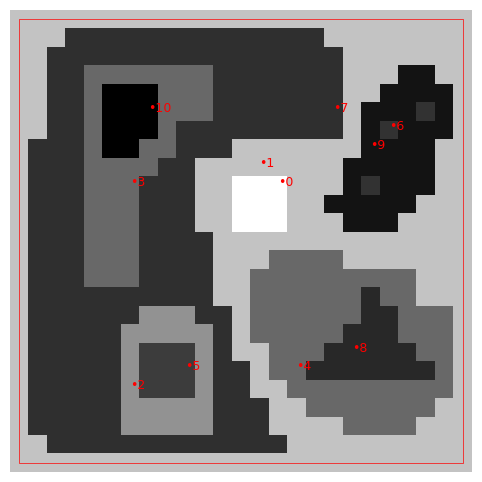

Each node is represented by <index>: <gray level>: <area>

                                0: 253: 625 
                                     |
                                1: 203: 616 
                    ┌────────────────┴────┬────────────┐
               2: 161: 277            4: 126: 84   6: 80: 38 
           ┌────────┴─────────┐           |            |     
      3: 126: 244          5: 90: 9   8: 72: 18    9: 54: 35 
     ┌─────┴──────┐                                          
 7: 78: 191   10: 38: 11 



Imagem and its max-tree representation. The indexes of max-tree nodes are shown as label in the imagem.


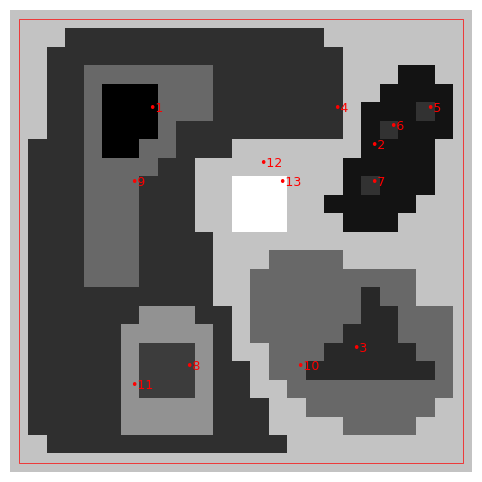

Each node is represented by <index>: <gray level>: <area>

                           1: 38: 625 
                               |
                           2: 54: 614 
    ┌──────────┬──────────┬────┴──────────────────────────┐
 5: 80: 1   6: 80: 1   7: 80: 1                       3: 72: 576                     
                                                          |                          
                                                      4: 78: 558                     
                                      ┌─────────────┬─────┴────────┬───────────┐     
                                  9: 126: 42   10: 126: 292   11: 161: 24   8: 90: 9 
                                                    |                                
                                               12: 203: 226                          
                                                    |                                
                                                13: 253: 9 


In [18]:
#adjust = mta.ComponentTreeAdjustmentByLeaf(mintree, maxtree)

adjust.updateTree(maxtree, L)

#after, pruning the maxtree
mintree.prunning(L)
del L

#reconstructed images of both trees
img_g_vector_maxtree = maxtree.reconstructionImage()
img_g_vector_mintree = mintree.reconstructionImage()

print("The reconstruction images are equals?", (img_g_vector_maxtree == img_g_vector_mintree).all() )
showTree(mintree)
print("\n\n")
showTree(maxtree)

List of leaves of the min-tree:
	 [NodeCT(id=9, level=54), NodeCT(id=8, level=72), NodeCT(id=5, level=90), NodeCT(id=10, level=38), NodeCT(id=7, level=78)] 



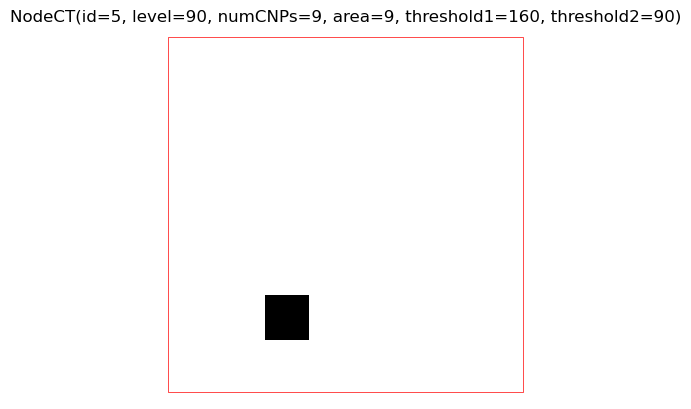

In [20]:
leaves_mintree = mintree.leaves()
print("List of leaves of the min-tree:\n\t", leaves_mintree, "\n")

L = leaves_mintree[2]
showNode(L)

f(p) = a =  90
g(p) = b =  161
F_λ: {38: [NodeCT(id=1, level=38)], 54: [NodeCT(id=2, level=54)], 72: [NodeCT(id=3, level=72)], 78: [NodeCT(id=4, level=78)], 161: [NodeCT(id=11, level=161)]}
F_λ>b: set()
The reconstruction images are equals? True
Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


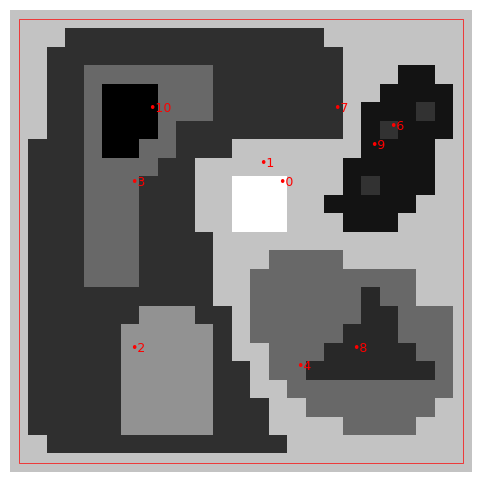

Each node is represented by <index>: <gray level>: <area>

                      0: 253: 625 
                           |
                      1: 203: 616 
           ┌───────────────┴───┬────────────┐
      2: 161: 277          4: 126: 84   6: 80: 38 
           |                   |            |     
      3: 126: 244          8: 72: 18    9: 54: 35 
     ┌─────┴──────┐                               
 7: 78: 191   10: 38: 11 



Imagem and its max-tree representation. The indexes of max-tree nodes are shown as label in the imagem.


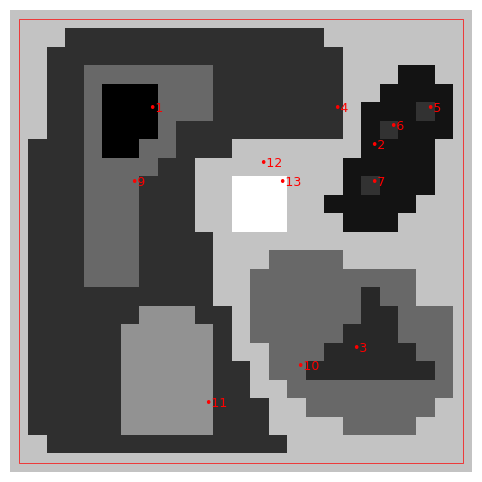

Each node is represented by <index>: <gray level>: <area>

                        1: 38: 625 
                            |
                        2: 54: 614 
    ┌──────────┬──────────┬─┴───────────────────────┐
 5: 80: 1   6: 80: 1   7: 80: 1                 3: 72: 576                
                                                    |                     
                                                4: 78: 558                
                                      ┌─────────────┼──────────────┐      
                                  9: 126: 42   10: 126: 292   11: 161: 33 
                                                    |                     
                                               12: 203: 226               
                                                    |                     
                                                13: 253: 9 


In [22]:

oldGrayLevel = L.level
newGrayLevel = L.parent.level

(F_λ, F_λb) = adjust.buildCollections(maxtree, L, newGrayLevel)

print("f(p) = a = ", oldGrayLevel)
print("g(p) = b = ", newGrayLevel)
print("F_λ:", F_λ)
print("F_λ>b:", F_λb)



adjust.updateTree(maxtree, L)

#after, pruning the maxtree
mintree.prunning(L)
del L

#reconstructed images of both trees
img_g_vector_maxtree = maxtree.reconstructionImage()
img_g_vector_mintree = mintree.reconstructionImage()

print("The reconstruction images are equals?", (img_g_vector_maxtree == img_g_vector_mintree).all() )
showTree(mintree)
print("\n\n")
showTree(maxtree)